Recently, we have more and more network (mostly undirected binary) generators are proposed to get synthetic network *similar* to target network(s). For instance, ERGM tries to get similar (weighted) graphlets structure, or dk-series tries to capture the distribution of graphlets. Some other more *heuristic* models take specific measures like *degree distribution*, *betweenness* as objectives and optimize the parameters. They get pretty good performance on some networks without too much knowledge. 

At the same time, I am thinking, although these models give pretty reasonable explanation on their parameterization and (sometimes) estimation, are they really indicating such *generating process*? So here I am working on a kinda *null model* for testing

> If we evolve random networks towards some objectives(for now, measures), can we get selected networks similar to the target networks?

Here I used word *selected* because such networks are evolved and selected based on fitness. You can also interpret this process (evolving and selecting) as synthesis of networks with parameter of objectives. That is, we don't parameterize the model, the measured objectives like degree/betweenness distribution are directly our parameters. The synthesis process is done by GA (searching).

### Reasons for GA
- Finding networks is close to discrete optimization problems
- GA has a mature framework for multi-objective optimization

## Proposed Steps
- [x] single target network, single objective (KS of degree distribution)
- [ ] single target network, multi-objective (degree, betweenness and clustering coefficient)
- [ ] run this model on multiple networks (not sure)

## Dataset
In this project, I will use brain functional connectivity networks as dataset. General idea of this processing is introduced in [1].

The session of rfMRI_REST1_LR of subject 129028 is selected.


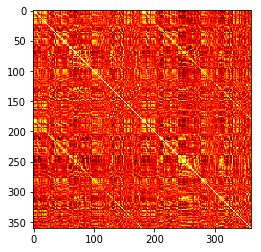

In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import os    # for files IO
import pandas as pd    # for files IO and dataframe
import networkx as nx    # for network
import random    # for GA

from pandas_datareader import data    # for files IO
from scipy.io import loadmat    # for files IO
from scipy.stats import ks_2samp    # for KS-test
# All these deap's are for GA
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from sklearn.decomposition import PCA

# fetch args
data_loc = os.environ['DATA']
np.random.seed(0)

# function for loading TS
def load_TS(data_loc, subj, sess):
    TS_mat = loadmat(data_loc+'/results_SIFT2/'+subj+'/fMRI/'+sess+'/FC/TSz_glasser_GS_bp_z_subc.mat')
    return TS_mat['TS_merged']

# function for loading FC
def load_FC(data_loc, subj, sess):
    return np.loadtxt(open(data_loc+"/HCP_100S_fMRI_FC/"+subj+"_"+sess+".csv", "rb"), delimiter=",")

# load the data from a random selected subject
subj = np.random.choice(os.listdir(data_loc+'/results_SIFT2/'))
sess = 'rfMRI_REST1_LR'

# check if dataset is successfully imported
print('The session of '+sess+' of subject '+ subj + ' is selected.')
corrmat = load_FC(data_loc, subj, sess)
_=plt.imshow(corrmat, cmap='hot', interpolation='nearest')
# plt.show()

### Use `networkX` to generate the network and check the topology
Here we binarize the adjacency matrix with a simple threshold $r\geq0.2$. The network is visualized as follows.

In [3]:
# binarize the matrix
cutoff = 0.2
corrmat[corrmat < cutoff] = 0
corrmat[np.eye(corrmat.shape[0],dtype=bool)] = 0
corrmat[corrmat > 0] = 1

Name: 
Type: Graph
Number of nodes: 360
Number of edges: 11739
Average degree:  65.2167
The density is 0.18166202414113278. The degree distribution is


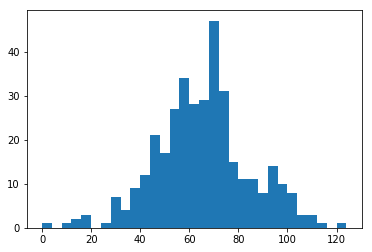

In [4]:
# get the network
G=nx.from_numpy_matrix(corrmat)

# plot the basic information
print(nx.info(G))
print('The density is '+str(nx.density(G))+'. The degree distribution is')
deg = np.array(nx.degree(G))[:,1]
plt.hist(deg, bins=np.arange(0, max(deg)+1, 4))
plt.show()

Before we get into the optimization, here we define some stats functions for later use. About the KS-test used here, it's a 2 sample test for testing if two samples are coming from the same distribution. It will give 2 return values. A $D$-stat and corresponding $p$ value. The null hypothesis is **the 2 samples are drawn from the same distribution**. As a result, higher $D$ means lower $p$ meaning rejection. So the objective is $D$-stat of KS test of the original degree and the new degree. Lower value is better so it's a minimization problem.

In [97]:
# Define functions for network statistics
def mat_from_list(low_tri):
    adj_mat = np.zeros((N,N), dtype=float)
    adj_mat[np.tril_indices(N, k=-1)] = low_tri
    return adj_mat + adj_mat.transpose()

def graph_from_mat(mat):
    return nx.from_numpy_matrix(mat)

def get_degree(G):
    return np.array(nx.degree(G))[:,1]

def get_between(G):
    return np.array(list(nx.betweenness_centrality(G).values()))

def get_cc(G):
    return np.array(list(nx.clustering(G).values()))

def KS_D(OG, newG):
    return ks_2samp(OG,newG)[0]

# parameter setting
OG_deg = get_degree(G)
OG_between = get_between(G)
OG_cc = get_cc(G)
OG_den = nx.density(G)

## Single target network, similar *degree distribution*
In this step, our target is to find the optimal networks with the closest degree distribution w/ GA. That is, we randomly initialize networks w/ same # of nodes and edges. Then by GA we try to evolve the networks into target networks. The binary adjacency matrices `corrmat`'s are split and recombined with GA and selected by fitness(similarity of degree distribution)

- **Objective**: minimize the $D$-stat of degree distribution between target network and my individual
- **Individual**: undirected network, networkX object here
- **Crossover**: choose some nodes, replace the all appended edges w/ the other individual

In [6]:
# setup individuals and populations
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

N = G.number_of_nodes()

toolbox = base.Toolbox()

toolbox.register("random_edge", 
                 np.random.binomial, 
                 1,
                 OG_den)
toolbox.register("individual", 
                 tools.initRepeat, 
                 creator.Individual, 
                 toolbox.random_edge, 
                 n=int(N*(N-1)/2))
toolbox.register("population",
                tools.initRepeat,
                list, 
                toolbox.individual)

Next we need to define the fitness function and crossover for our GA. As we discussed before, at this stage, I only want to get networks with similar degree distribution. The similarity between networks are evaluated by KS test as stated before. The crossover is done by randomly selecting some nodes and then exchanging all edges having at least one of these nodes as endpoint. 

In [7]:
# setup the evalutaion function
def evalInd(individual):
    indG = graph_from_mat(mat_from_list(individual))
    return KS_D(OG_deg, get_degree(indG)),

def cxInds(ind1, ind2):
    mat1 = mat_from_list(ind1)
    temp1 = mat1.copy()
    mat2 = mat_from_list(ind2)
    temp2 = mat2.copy()
    cxNodes = np.random.choice(np.arange(N), np.random.randint(0,N), replace=False)
    for ind in cxNodes:
        mat1[:,ind] = temp2[:,ind]
        mat2[:,ind] = temp1[:,ind]
        mat1[ind,:] = temp2[ind,:]
        mat2[ind,:] = temp1[ind,:]
    ind1[:] = mat1[np.tril_indices(N, k=-1)]
    ind2[:] = mat2[np.tril_indices(N, k=-1)]
    return ind1, ind2

toolbox.register("evaluate", evalInd)
toolbox.register("mate", cxInds)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
NGEN = 50
MU = 50
LAMBDA = 100
CXPB = 0.7
MUTPB = 0.2

pop = toolbox.population(n=MU)
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                         halloffame=hof,verbose=False)

Here we can check the best network generated, Because there is only one target, the **best** network is selected and shown here.

Name: 
Type: Graph
Number of nodes: 360
Number of edges: 11666
Average degree:  64.8111
The density of new net is 0.1805323429278861. The degree distribution is


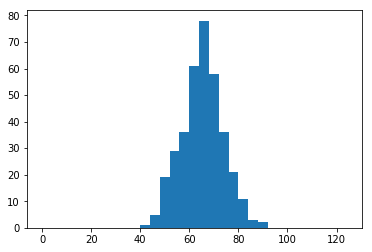

In [15]:
bG = graph_from_mat(mat_from_list(hof[0]))
print(nx.info(bG))
print('The density of new net is '+str(nx.density(bG))+'. The degree distribution is')
bdeg = np.array(nx.degree(bG))[:,1]
plt.hist(bdeg, bins=np.arange(0, max(OG_deg)+1, 4))
plt.show()

/home/dali/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


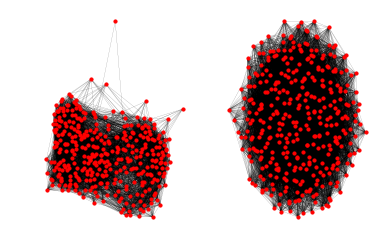

In [10]:
plt.subplot(1,2,1)
nx.draw(G, node_size=10, width=.1)
plt.subplot(1,2,2)
nx.draw(bG, node_size=10, width=.1)
plt.draw()

### Conclusion on single objective
We can find here the result is not very good. By the way, if we check the functional networks between different subjects/tasks, the KS-test result is very low. One thing to keep in mind, **degree distribution is highly related to density**. If the two networks have very different density, you are not likely to get a close degree distribution. In other words, if you already constrain identical density, the degree distribution can be very close. 

## Single target network, similar *degree, betweenness, clustering coefficient distribution*

In the single test we showed that constrain on single objective doesn't doing a very good job. I list some reasons here:
- The initial networks all having the same density (expectation) w/ target network. That results a low $D$ at the beginning. Not enough pressure then.
- The $D$-stat for different subjects/tasks are **very high**, meaning a very dissimilar distribution. But they are similar visually. Why?

Because **solely KS-test of degree distribution** is not a good measurement of similarity.

Name: 
Type: Graph
Number of nodes: 360
Number of edges: 14222
Average degree:  79.0111
The density is 0.2200866604766326. The degree distribution is


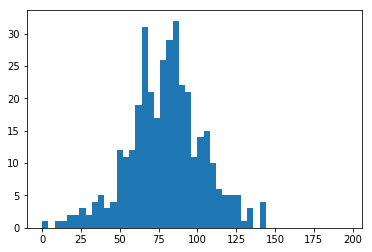

Name: 
Type: Graph
Number of nodes: 360
Number of edges: 16976
Average degree:  94.3111
The density is 0.2627050448777468. The degree distribution is


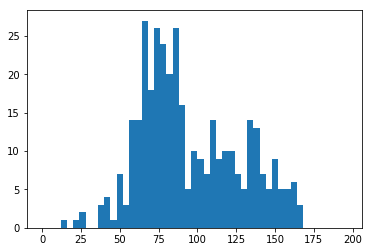

Name: 
Type: Graph
Number of nodes: 360
Number of edges: 14299
Average degree:  79.4389
The density is 0.22127824203033117. The degree distribution is


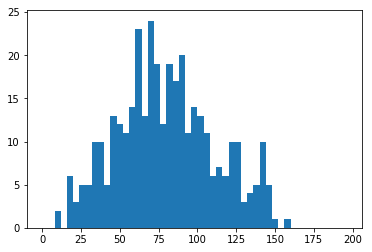

Name: 
Type: Graph
Number of nodes: 360
Number of edges: 15098
Average degree:  83.8778
The density is 0.2336428350355927. The degree distribution is


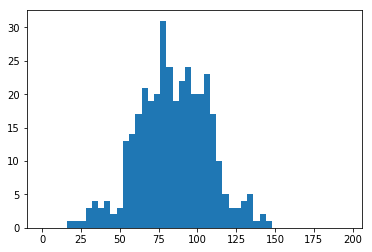

Name: 
Type: Graph
Number of nodes: 360
Number of edges: 16156
Average degree:  89.7556
The density is 0.25001547508511296. The degree distribution is


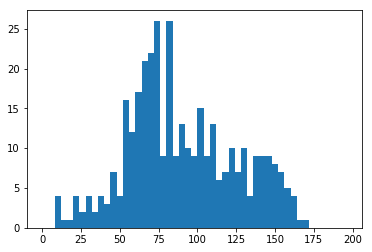

In [28]:
subj_list = os.listdir(data_loc+'/results_SIFT2/')
sess = 'rfMRI_REST1_LR'

for subj in np.random.choice(os.listdir(data_loc+'/results_SIFT2/'), 5):
    corrmat = load_FC(data_loc, subj, sess)
    cutoff = 0.2
    corrmat[corrmat < cutoff] = 0
    corrmat[np.eye(corrmat.shape[0],dtype=bool)] = 0
    corrmat[corrmat > 0] = 1
    G=nx.from_numpy_matrix(corrmat)
    print(nx.info(G))
    print('The density is '+str(nx.density(G))+'. The degree distribution is')
    deg = np.array(nx.degree(G))[:,1]
    plt.hist(deg, bins=np.arange(0, 200, 4))
    plt.show()

In [ ]:
# setup individuals and populations
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0,-1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

N = G.number_of_nodes()

toolbox = base.Toolbox()

toolbox.register("random_edge", 
                 np.random.binomial, 
                 1,
                 OG_den)
toolbox.register("individual", 
                 tools.initRepeat, 
                 creator.Individual, 
                 toolbox.random_edge, 
                 n=int(N*(N-1)/2))
toolbox.register("population",
                tools.initRepeat,
                list, 
                toolbox.individual)

# setup the evalutaion function
def evalInd(individual):
    indG = graph_from_mat(mat_from_list(individual))
    return (KS_D(OG_deg, get_degree(indG)),
            KS_D(OG_between, get_between(indG)),
            KS_D(OG_cc, get_cc(indG)))

def cxInds(ind1, ind2):
    mat1 = mat_from_list(ind1)
    temp1 = mat1.copy()
    mat2 = mat_from_list(ind2)
    temp2 = mat2.copy()
    cxNodes = np.random.choice(np.arange(N), np.random.randint(0,N), replace=False)
    for ind in cxNodes:
        mat1[:,ind] = temp2[:,ind]
        mat2[:,ind] = temp1[:,ind]
        mat1[ind,:] = temp2[ind,:]
        mat2[ind,:] = temp1[ind,:]
    ind1[:] = mat1[np.tril_indices(N, k=-1)]
    ind2[:] = mat2[np.tril_indices(N, k=-1)]
    return ind1, ind2

toolbox.register("evaluate", evalInd)
toolbox.register("mate", cxInds)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.2)
toolbox.register("select", tools.selNSGA2)

# start the GA
NGEN = 50
MU = 50
LAMBDA = 100
CXPB = 0.7
MUTPB = 0.2

pop = toolbox.population(n=MU)
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                         halloffame=hof)

## Reference
1. Bullmore, Ed, and Olaf Sporns. "Complex brain networks: graph theoretical analysis of structural and functional systems." Nature Reviews Neuroscience 10.3 (2009): 186.